import sys
!{sys.executable} -m pip install pydot

In [1]:
import pandas as pd
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
from matplotlib.ticker import ScalarFormatter
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

In [2]:
year = "1992"

In [3]:
BuLi = pd.read_csv(r"DataFootball/"+year+"_german_bundesliga_1.csv")
PL = pd.read_csv(r"DataFootball/"+year+"_english_premier_league.csv")
SA = pd.read_csv(r"DataFootball/"+year+"_italian_serie_a.csv")
PD = pd.read_csv(r"DataFootball/"+year+"_spanish_primera_division.csv")
L1 = pd.read_csv(r"DataFootball/"+year+"_french_ligue_1.csv")
NOS = pd.read_csv(r"DataFootball/"+year+"_portugese_liga_nos.csv")
Ere = pd.read_csv(r"DataFootball/"+year+"_dutch_eredivisie.csv")
EC = pd.read_csv(r"DataFootball/"+year+"_english_championship.csv")
Rus = pd.read_csv(r"DataFootball/"+year+"_russian_premier_liga.csv")

In [4]:
DF = pd.concat([BuLi, PL, SA,
                  PD, L1, NOS, 
                  Ere, EC, Rus],ignore_index=True)

In [5]:
DF.shape

(2671, 12)

In [6]:
def DelCol(DF):
    
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    #del DF["player_name"]
    #del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)
DF = DelCol(DF)
DF.head()
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]
DF.head()

,club_name,player_name,club_involved_name,transfer_movement,fee_cleaned
0,1. FC Köln,Andrzej Kobylanski,Siarka T.,in,0.270
1,1. FC Köln,Dirk Lehmann,A. Aachen II,in,0.014
2,1. FC Köln,Kim Christofte,Bröndby IF,in,0.122
3,1.FC Kaiserslautern,Martin Wagner,1.FC Nuremberg,in,0.450
4,1.FC Kaiserslautern,Marcus Marin,Stuttg. Kickers,in,0.648


In [7]:
## There is a problem with "double names", e.g. Leicester and Leicester City
def Change(DF,old,new):
    DF.loc[DF["club_name"].isin([old]), ["club_name"]] = new
    DF.loc[DF["club_involved_name"].isin([old]), ["club_involved_name"]] = new
    return DF

In [8]:
old = ["Leicester", "SC Paderborn", "Real Betis", "Sassuolo", "Liverpool", "Watford", "Queens Park Rangers",
       "Brighton & Hove Albion", "Manchester United", "Inter", "UC Sampdoria", "Genoa", "Juventus FC", "Braga",
      "Zenit S-Pb", "Valencia CF", "Marseille", "Espanyol", "Villarreal", "Getafe", "Toulouse", "Cardiff",
      "Paris Saint-Germain", "SL Benfica", "R. Strasbourg", "Racing Club", "Spartak Moscow", "Ajax Amsterdam",
      "Feyenoord Rotterdam", "Dijon FCO", "F. Düsseldorf", "Man City", "E. Frankfurt", "West Ham United",
      "Huddersfield Town", "Charlton", "Nottm Forest", "Swansea", "SS Lazio", "Arsenal FC", "Newcastle",
      "Chelsea FC", "Vitesse Arnheim", "Heerenveen", "Levante", "Brentford", "Bologna", "SV Werder Bremen",
      "Ipswich", "Montpellier", "Bolton", "Marítimo", "Millwall","FC Sochaux-Montbéliard", "Blackpool FC",
       "ES Troyes AC", "Middlesbrough FC", "Vit. Guimarães", "Doncaster", "Norwich City", "Coventry City",
       "Roda JC", "Rostov", "Heerenveen", "Bilbao Athletic", "Leeds United", "Derby", 
       "Dep. La Coruña", "G. Bordeaux", "Naval", "CF Estrela", "Twente FC", "Willem II", 
      "Stade Rennais FC", "Athletic", "1.FC K'lautern", "Preston", "Spurs", "Bor. Dortmund", '1. FC Kaiserslautern',
      'Anzhi', 'Bay. Leverkusen', 'Birmingham',  'Blackburn', 'Brescia', "Bor. M'gladbach", 'Burnley', 'Krasnodar',
      'Loko Moscow','Parma', 'Preston NE','Scunthorpe Utd.','Sheffield Utd.','Sunderland','TSG Hoffenheim',
       'Tottenham Hotspur','West Bromwich Albion','Wigan Athletic','Wolves', "Southampton", "Alavés",
      "FC Penafiel", "Luton Town", "Academica Coimbra", "Plymouth Argyle", "CD Nacional", "Fulham FC",
      'AC Fiorentina','Atalanta', "Sparta R.", "Vitesse Arnhem", 'Udinese', 
       "Padova" ,'FC Internazionale', 'Milan', "Genoa 1893", "Piacenza FC"]

In [9]:
new = ["Leicester City", "SC Paderborn 07", "Real Betis Balompié", "US Sassuolo", "Liverpool FC", "Watford FC",
      "QPR", "Brighton", "Man Utd", "Inter Milan", "Sampdoria", "Genoa CFC", "Juventus", "SC Braga", 
       "Zenit St. Petersburg", "Valencia", "Olympique Marseille", "RCD Espanyol Barcelona", "Villarreal CF", 
       "Getafe CF", "FC Toulouse", "Cardiff City", "Paris SG", "Benfica", "RC Strasbourg Alsace", "RC Strasbourg Alsace",
      "Spartak", "Ajax", "Feyenoord", "Dijon", "Fortuna Düsseldorf", "Manchester City","Eintracht Frankfurt", "West Ham",
       "Huddersfield","Charlton Athletic", "Nottingham Forest", "Swansea City", "Lazio", "Arsenal", "Newcastle United",
       "Chelsea","Vitesse", "SC Heerenveen", "Levante UD", "Brentford FC", "Bologna FC 1909", "Werder Bremen",
      "Ipswich Town", "Montpellier HSC", "Bolton Wanderers", "CS Marítimo", "Millwall FC","FC Sochaux", "Blackpool",
      "Troyes", "Middlesbrough", "Vitória Guimarães SC", "Doncaster Rovers", "Norwich", "Coventry", 
       "Roda JC Kerkrade", "FK Rostov", "SC Heerenveen", "Athletic Bilbao", "Leeds", "Derby County",
      "Deportivo de La Coruña", "FC Girondins Bordeaux", "Naval 1º de Maio", "CF Estrela Amadora SAD", "Twente Enschede FC",
      "Willem II Tilburg", "Stade Rennais", "Athletic Bilbao", "1. FC Kaiserslautern", "Preston North End", "Tottenham Hotspurs",
      "Borussia Dortmund", '1.FC Kaiserslautern','Anzhi Makhachkala','Bayer 04 Leverkusen','Birmingham City','Blackburn Rovers',
      'Brescia Calcio', 'Borussia Mönchengladbach', 'Burnley FC','Kuban Krasnodar','Lokomotiv Moscow','Parma FC','Preston North End',
      'Scunthorpe United','Sheffield United','Sunderland AFC','TSG 1899 Hoffenheim','Tottenham Hotspurs','West Brom',
      'Wigan','Wolverhampton Wanderers', "Southampton FC", "Deportivo Alavés", "Penafiel", "Luton", "Coimbra",
      "Plymouth", "Nacional", "Fulham",'Fiorentina','Atalanta BC', "Sparta Rotterdam", "Vitesse", 'Udinese Calcio',
      "Calcio Padova",'Inter Milan', 'Milan AC', "Genoa CFC", "Piacenza"]

In [10]:
for i in range(len(new)):
    DF = Change(DF, old[i], new[i])
    BuLi = Change(BuLi,old[i], new[i])
    PL = Change(PL,old[i], new[i])
    PD = Change(PD,old[i], new[i])
    SA = Change(SA,old[i], new[i])
    L1 = Change(L1,old[i], new[i])
    NOS = Change(NOS, old[i], new[i])
    Ere = Change(Ere, old[i], new[i])
    EC = Change(EC, old[i], new[i])
    Rus = Change(Rus, old[i], new[i])

In [11]:
set(DF["club_name"])

{'1. FC Köln',
 '1.FC Kaiserslautern',
 '1.FC Nuremberg',
 '1.FC Saarbrücken',
 'AJ Auxerre',
 'AS Monaco',
 'AS Roma',
 'Ajax',
 'Ancona Calcio',
 'Arsenal',
 'Aston Villa',
 'Atalanta BC',
 'Barnsley FC',
 'Bayer 04 Leverkusen',
 'Bayer 05 Uerdingen',
 'Bayern Munich',
 'Benfica',
 'Birmingham City',
 'Blackburn Rovers',
 'Boavista FC',
 'Borussia Dortmund',
 'Brentford FC',
 'Brescia Calcio',
 'Bristol City',
 'Burgos CF',
 'CSKA Moscow',
 'Cagliari Calcio',
 'Cambuur-Leeuwarden bvo',
 'Celta de Vigo',
 'Charlton Athletic',
 'Chelsea',
 'Coventry',
 'Crystal Palace',
 'Deportivo de La Coruña',
 'Derby County',
 'Eintracht Frankfurt',
 'Everton FC',
 'FC Barcelona',
 'FC Girondins Bordeaux',
 'FC Groningen',
 'Feyenoord',
 'Fiorentina',
 'Foggia Calcio',
 'Hamburger SV',
 'Huddersfield',
 'Inter Milan',
 'Ipswich Town',
 'Juventus',
 'Karlsruher SC',
 'Lazio',
 'Leeds',
 'Liverpool FC',
 'Luton',
 'MVV Maastricht',
 'Man Utd',
 'Manchester City',
 'Middlesbrough',
 'Milan AC',
 'Mill

In [12]:
# Now that all club names are brought "in line", save the names of the clubse whose full leagues are in the data 
# that means the clubs currently in "club_name" column

Names = set(DF["club_name"])
Names = list(Names)

# If any of these clubs appears on the club_involved_name-column, then the transfer is included twice in our data
# so we delete all "out"-directions of the double transfers

In [13]:
len(Names)

91

In [14]:
DF_clean = pd.DataFrame(columns = DF.columns)

for i in range(DF.shape[0]):
    if not(DF["club_involved_name"].iloc[i] in Names and DF["transfer_movement"].iloc[i]=="out"):
        DF_clean= DF_clean.append(DF.iloc[i])
        
DF = DF_clean
DF = DF.reset_index()
del DF["index"]
del DF["player_name"]

In [15]:
print(DF_clean.loc[DF_clean["player_name"]== "Javi Martínez"]) # Not counted twice!!

Empty DataFrame
Columns: [club_name, player_name, club_involved_name, transfer_movement, fee_cleaned]
Index: []


## Clean the Data

In [16]:
# encode "direction" of transfers: "club_name" is the buyer, "club_involved_name" the seller
for i in range(DF.shape[0]):
    if DF["transfer_movement"].iloc[i] == "out": # switch positions
        source = DF["club_name"].iloc[i]
        DF["club_name"].iloc[i] = DF["club_involved_name"].iloc[i]
        DF["club_involved_name"].iloc[i] = source

del DF["transfer_movement"]

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
DF.head()

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,Siarka T.,0.270
1,1. FC Köln,A. Aachen II,0.014
2,1. FC Köln,Bröndby IF,0.122
3,1.FC Kaiserslautern,1.FC Nuremberg,0.450
4,1.FC Kaiserslautern,Stuttg. Kickers,0.648


In [18]:
# sort alphabetically
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]

DF.head()

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,Siarka T.,0.270
1,1. FC Köln,A. Aachen II,0.014
2,1. FC Köln,Bröndby IF,0.122
3,1.FC Kaiserslautern,1.FC Nuremberg,0.450
4,1.FC Kaiserslautern,Stuttg. Kickers,0.648


In [19]:
DF_clean.shape

(237, 5)

### Combine multiple transfers between clubs a and b

In [20]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [21]:
DF = AddFees(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
DF = DF.reset_index()
del DF["index"]
DF

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,Siarka T.,0.270
1,1. FC Köln,A. Aachen II,0.014
2,1. FC Köln,Bröndby IF,0.122
3,1.FC Kaiserslautern,1.FC Nuremberg,0.450
4,1.FC Kaiserslautern,Stuttg. Kickers,0.648
...,...,...,...
197,Wimbledon FC,Brentford FC,0.900
198,Wimbledon FC,Chelsea,0.747
199,Wolverhampton Wanderers,Norwich,0.340
200,Wolverhampton Wanderers,Coventry,0.101


## 10 x 10 Matrix
Just show the transfer streams between the nine leagues (+ outside as tenth column/row)

In [23]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga

BLList = pd.Series(BL_teams)
PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))
NOSList = pd.Series(list(set(NOS["club_name"])))
EreList = pd.Series(list(set(Ere["club_name"])))
ECList = pd.Series(list(set(EC["club_name"])))
RusList = pd.Series(list(set(Rus["club_name"])))
ListNames = list([BLList, PLList, SAList, PDList, L1List, NOSList, EreList, ECList, RusList])

In [24]:
def flatten(t): # combine sublists into one list
    return [item for sublist in t for item in sublist]

In [25]:
# Regard each league individually
BL0 = DF.loc[DF["club_name"].isin( BLList)]
PL0 = DF.loc[DF["club_name"].isin( PLList)]
SA0 = DF.loc[DF["club_name"].isin( SAList)]
PD0 = DF.loc[DF["club_name"].isin( PDList)]
L10 = DF.loc[DF["club_name"].isin( L1List)]
NOS0 = DF.loc[DF["club_name"].isin( NOSList)]
Ere0 = DF.loc[DF["club_name"].isin( EreList)]
EC0 = DF.loc[DF["club_name"].isin( ECList)]
Rus0 = DF.loc[DF["club_name"].isin( RusList)]
Leagues = list([BL0, PL0, SA0, PD0, L10, NOS0, Ere0, EC0, Rus0])
print(Leagues[1])
print(flatten(ListNames))
Other = DF.loc[~DF["club_name"].isin(flatten(ListNames))]
print(Other)
Leagues.append(Other)

              club_name club_involved_name  fee_cleaned
17              Arsenal            Everton        2.700
18              Arsenal         Bröndby IF        1.440
19          Aston Villa       Liverpool FC        3.539
35     Blackburn Rovers   Newcastle United        0.432
36     Blackburn Rovers      Leyton Orient        0.172
..                  ...                ...          ...
181  Tottenham Hotspurs         Portsmouth        2.430
182  Tottenham Hotspurs     Southampton FC        0.765
196        Wimbledon FC      Leyton Orient        0.282
197        Wimbledon FC       Brentford FC        0.900
198        Wimbledon FC            Chelsea        0.747

[63 rows x 3 columns]
['Hamburger SV', '1. FC Köln', 'Karlsruher SC', '1.FC Saarbrücken', 'VfL Bochum', 'SG Dynamo Dresden', 'Bayern Munich', 'SG Wattenscheid 09', 'Bayer 05 Uerdingen', 'VfB Stuttgart', 'Eintracht Frankfurt', 'FC Schalke 04', '1.FC Nuremberg', 'Werder Bremen', 'Borussia Mönchengladbach', '1.FC Kaiserslautern'

In [26]:
print(len(Leagues))
print(len(Leagues[0:(len(Leagues)-1)]))

10
9


In [27]:
def StreamLeagues(Liga, Others):
    # takes DF of league as Liga and list of other league names as Others
    # calculates how much the aggregated transfers from all other Leagues (Others) to the league "Liga" is
    Out = np.zeros(len(Others)+1) 
    
    for i in range(len(Others)): # -1: treat "other leagues than top 9" differently
        # Data frame of transfers from Others[i] to Liga
        df2 = Liga.loc[Liga["club_involved_name"].isin(Others[i])]
        Out[i] = sum(df2["fee_cleaned"])
        
        
    # final output "all leagues except the top 9"    
    dfrest = Liga.loc[~Liga["club_involved_name"].isin(flatten(Others[0:(len(Others)-1)]))]  
    Out[len(Others)] = sum(dfrest["fee_cleaned"])
    return(Out)

In [28]:
StreamLeagues(BL0, ListNames)

array([11.395,  0.   ,  7.52 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  7.568])

In [29]:
StreamLeagues(Other, ListNames)

array([2.208, 8.433, 6.3  , 0.   , 3.69 , 0.   , 0.799, 6.094, 0.   ,
       0.   ])

In [30]:
MatrixLeagues = np.zeros((10,10))
i = 0
for L in Leagues:
    MatrixLeagues[i,:] = StreamLeagues(L, ListNames)
    i +=1

print(MatrixLeagues.shape)
print(MatrixLeagues[0])
Names = list(["BL", "PL", "SerieA", "LaLiga", "Ligue1", "Portug", "NED", "Championship", "RUS", "Others"])

# DF10x10 column i shows all transfers out of league i
# DF10x10 row j shows all transfers to league j
DF10x10 = pd.DataFrame(data = MatrixLeagues,
                      index = Names,
                      columns = Names)
print(DF10x10)

(10, 10)
[11.395  0.     7.52   0.     0.     0.     0.     0.     0.     7.568]
                  BL      PL  SerieA  LaLiga  Ligue1  Portug    NED  \
BL            11.395   0.000   7.520   0.000   0.000     0.0  0.000   
PL             0.000  43.706   0.000   0.000   2.943     0.0  0.000   
SerieA        13.595   8.190  23.283   1.800  10.800     0.0  2.600   
LaLiga         0.000   0.000   0.000   4.808   0.000     0.0  0.327   
Ligue1         0.000   0.450   6.300   0.000   0.000     0.0  0.000   
Portug         0.000   0.000   0.000   0.000   0.000     0.0  0.000   
NED            0.000   0.000   0.000   0.000   0.000     0.0  4.216   
Championship   0.000  25.937   0.000   0.000   2.943     0.0  0.000   
RUS            0.000   0.000   0.000   0.000   0.000     0.0  0.000   
Others         2.208   8.433   6.300   0.000   3.690     0.0  0.799   

              Championship   RUS  Others  
BL                   0.000  0.00   7.568  
PL                  12.650  0.36  23.697  
SerieA  

#### Symmetric 10x10

In [31]:
Symmetric = (np.transpose(MatrixLeagues) + MatrixLeagues)
DFsym = pd.DataFrame(data = Symmetric,
                      index = Names,
                      columns = Names)
print(DFsym)
DFsym.to_csv("10x10_"+year)

                  BL      PL  SerieA  LaLiga  Ligue1  Portug    NED  \
BL            22.790   0.000  21.115   0.000   0.000    0.00  0.000   
PL             0.000  87.412   8.190   0.000   3.393    0.00  0.000   
SerieA        21.115   8.190  46.566   1.800  17.100    0.00  2.600   
LaLiga         0.000   0.000   1.800   9.616   0.000    0.00  0.327   
Ligue1         0.000   3.393  17.100   0.000   0.000    0.00  0.000   
Portug         0.000   0.000   0.000   0.000   0.000    0.00  0.000   
NED            0.000   0.000   2.600   0.327   0.000    0.00  8.432   
Championship   0.000  38.587   1.530   0.000   2.943    0.00  0.000   
RUS            0.000   0.360   0.000   0.000   0.000    0.00  0.000   
Others         9.776  32.130  53.770   2.520  16.054    2.25  2.350   

              Championship   RUS  Others  
BL                   0.000  0.00   9.776  
PL                  38.587  0.36  32.130  
SerieA               1.530  0.00  53.770  
LaLiga               0.000  0.00   2.520  
Lig

## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [32]:
DFun =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [33]:
DFun["club1"] = np.minimum(DF['club_name'], DF['club_involved_name']) 
DFun["club2"] = np.maximum(DF['club_name'], DF['club_involved_name']) 

In [34]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [35]:
DFun = AddFeesUndirected(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [36]:
G = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [37]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga
BLList = pd.Series(BL_teams)

PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [38]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BLList.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

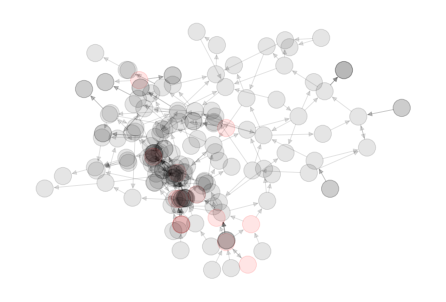

In [39]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [40]:
def Colour1(node):
    if np.sum(BLList.isin([node])):
        out = "red"
    elif np.sum(PLList.isin([node])):
        out = "blue"
    elif np.sum(SAList.isin([node])):
        out = "green" 
    elif np.sum(PDList.isin([node])):
        out = "yellow"
    elif np.sum(L1List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [41]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

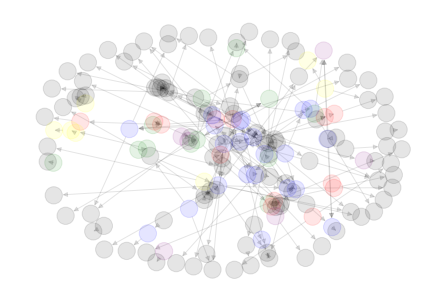

In [42]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)


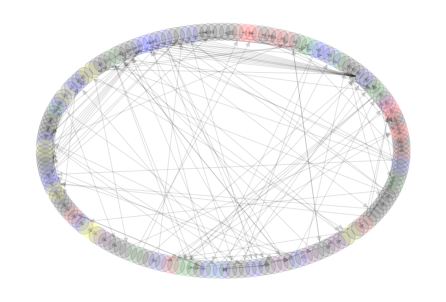

In [43]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks
#plt.savefig(year+"_Circular")

In [44]:
# Visual inspection: much less "Small World"-connected than before!

In [45]:
net = Network("800px", "800px",notebook=True)
net.from_nx(G)
net.show("Test.html")

## Pyvis

In [46]:
g = Network("800px", "800px",notebook=True)
g.toggle_physics(True)
G = nx.from_pandas_edgelist(DFun, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [47]:
def Colour(node):
    # from https://www.hexcolortool.com/#f429ff,0.33
    if np.sum(BLList.isin([node])):
        out = "rgba(244, 15, 11, 0.66)"
    elif np.sum(PLList.isin([node])):
        out = "rgba(41, 155, 255, 0.66)"
    elif np.sum(SAList.isin([node])):
        out = "rgba(41, 255, 77, 0.66)" 
    elif np.sum(PDList.isin([node])):
        out = "rgba(255, 241, 41, 0.66)"
    elif np.sum(L1List.isin([node])):
        out = "rgba(244, 41, 255, 0.66)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [48]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {"physics":False
              })

In [49]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [50]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [51]:
for i in range(DFun.shape[0]):
    g.add_edge(DFun["club_name"].iloc[i], 
              DFun["club_involved_name"].iloc[i],
              value=DFun["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [52]:

#g.show_buttons(filter_=["nodes", "edges", "physics"])
g.show("Test.html")

In [53]:
#g.save_graph(year+"_allLeagues.html")

## Analysis

In [54]:
G_undir = nx.from_pandas_edgelist(DFun, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [55]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

#### Small World

In [56]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]
SepList20 = ["CD Nacional", "Al-Batin", "Shimizu S-Pulse", "Portimonense SC", "SV Sandhausen",
            "CD Tondela", "Coventry"]
SepList19 = ["Vitória Setúbal FC","RKC Waalwijk","Portimonense SC","ADO Den Haag","Sparta Rotterdam",
             "FC Paços de Ferreira", "FK Ufa"]
SepList18 = ["CD Santa Clara", "Pau FC", "FC Emmen", "KS Samara","Khimki", "Tottenham Hotspurs",
            "C. Rizespor", "CD Nacional"]
SepList17 = ["Omiya Ardija", "SK Brann"]
SepList16 = ["FK Orenburg","Rotherham United","Belenenses SAD", "SC Heerenveen","MVV Maastricht",
            "Ross County", "GD Chaves"]
SepList15 = ["Boavista FC", "RSC Charleroi", "Helmond Sport","Lienden","Go Ahead Eagles"]
SepList14 = [ "Cracovia","Gaish","FK Ufa", "FC Nantes", "Brisbane Roar", "Shinnik"]
SepList13 = ["CFR Cluj","Zawisza","Académica Coimbra", "Tom Tomsk","Rio Ave FC","Alianza Lima",
             "Belenenses SAD","Waterford FC", "Leeds"]
SepList12 = ["Mordovia Saransk","Telstar", "CS Marítimo"]
SepList11 = ["Rio Ave FC","SC Olhanense","Sheriff", "Indjija"]
SepList10 = ["SM Caen","CS Marítimo","Sligo Rovers", "Roda JC Kerkrade", "Athletic Bilbao", 
             "Watford FC", "Cracovia","FK Rostov"]
SepList09 = ["AS Trencin", "Santo André","Anorthosis", "Sharjah FC"]
SepList08 = ["Ittihad"]
SepList07 = ["CF Estrela Amadora SAD"]
SepList06 = ["Mordovia", "Amkar Perm", "Zrinjski Mostar","Skoda Xanthi", "Tigre"]
SepList05 = ["Hertha BSC",  "FC Flora", "Guarani", "Crewe Alexandra", "Penafiel","Moreirense"]
SepList04 = ["SC Beira-Mar", "Planète Champ.", "FC Seoul", "FC Empoli", "Treviso",
             "Spartak Vladikavkaz", "Reading FC"]
SepList03 = ["PSV Eindhoven", "Huachipato FC", "Portimonense", "AC Perugia", "FC National" ,
             "CD Numancia", "SC Freiburg", "Barnsley FC", "Rayo Mallecano", "Steaua Bukarest",
             "Real Sociedad", "Bayer 04 Leverkusen", "Real Zaragoza", "Como", "Al-Jazira", 
             "AEK Athens", "Rayo Vallecano"]
SepList02 = [ 'Celta de Vigo', 'Racing Santander', 'VfB Stuttgart', 'Torino Calcio', 
             'Feyenoord', 'SW Bregenz', 'União de Leiria','AJ Auxerre','Sokol Saratov', 'Como Calcio']
SepList01 = ["AZ Alkmaar", "Levski Sofia", "Rostselmash Rostov", "NAC Breda", "Sporting Gijón", 
             "Exeter City", "Volta Redonda", "Sokol Saratov", "Obolon Kyiv", "Vojvodina", "EA Guingamp",
             "Wycombe", "Dinamo Moscow", "Lokomotiv Moscow", "CSKA Moscow", "Rubin Kazan", "Dinamo S-Pb"] 
                # Problem 2001: Russian sub-cluster
SepList00 = ["Belshina", "Lyngby BK", "Stoke City", "Sport Recife", "Zemun", "Deportivo Alavés", 
             "NAC Breda", "AS Bari", "Lev. Maardu", "Gaz Metan", "Millwall FC", "Pskov"]
SepList99 =  ["FC Empoli", "Stavropol", "Saturn Ramenskoe", "Shinnik","FC Nantes", "Madureira-RJ",
             "FK Zvezdara", "Rosenborg BK", "CSKA Moscow", "FC Metz", "Werder Bremen"]
SepList98 = ["Rio Ave FC", "Rotor Volgograd", "FC Alverca", "Felgueiras", "Gamba Osaka",
            "SC Braga", "Real Zaragoza", "MVV Maastricht", "SK Tavriya", "AC Le Havre"]
SepList97 = ["SV Meppen", "Lokomotiv-96", "Spartak", "Zenit St. Petersburg", "MSV Duisburg",
            "FC Copenhagen", 'Istanbulspor', "Newell's", 'Brescia Calcio','Steaua Bukarest',
            'Alania Vladikavkaz', "Hull City"]
SepList96 = ["Spartak", "SC Bastia", "AZ Alkmaar",'Olympique Lyon','Lokomotiv Moscow', "Zenit St. Petersburg",
            'Twente Enschede FC', "Vitesse","Sparta Rotterdam","SC Heerenveen", "FC Utrecht"]
SepList95 = ["Montijo", "AS Bari", "NAC Breda", "MVV Maastricht","Zenit St. Petersburg", "RC Lens",
            "Lech Poznan", "Lokomotiv Moscow", "Udinese Calcio"]
SepList94 = ["Ajax", "Sparta Rotterdam", "Stade Rennais", "Legia Warszawa", "US Cremonese", "Olympiacos",
             "NAC Breda", "Brentford FC", "KAA Gent", "Fulham", "SC Heerenveen", "Real Zaragoza", 
            ]
SepList93 = ["Valencia", "AS Roma","Real Madrid", "Paris SG", "Spartak", "AS Cannes", "Feyenoord", 
            'Uralmash Ekaterinburg','AC Parma',"Udinese Calcio"]
SepList92 = ["FC Zwolle", "MVV Maastricht", "Everton FC", "FC Barcelona", "Cannes", "Boavista",
            "RSC Anderlecht", "De Graafschap", "Burgos CF", 'Bayer 05 Uerdingen','Deportivo de La Coruña',
            "Eintracht Frankfurt"]

SepList = SepList92

DFcon= DFun.drop(DFun[ DFun['club_involved_name'].isin( SepList)].index)

DFcon = DFcon.drop(DFcon[ DFcon['club_name'].isin(SepList)].index)



In [57]:
G_undirconnected = nx.from_pandas_edgelist(DFcon, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )




In [58]:
# Quick check: plot
nt = Network('800px', '800px',notebook=True)
#nt.from_nx(G_undirconnected)


for node in G_undirconnected.nodes:
    nt.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })
    
for i in range(DFcon.shape[0]):
    nt.add_edge(DFcon["club_name"].iloc[i], 
              DFcon["club_involved_name"].iloc[i],
              value=DFcon["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })

nt.show('nx.html')
# Is connected!!

In [59]:
print(len(set(DFcon["club_name"])))
set(DFcon["club_name"])

95


{'1. FC Köln',
 '1.FC Kaiserslautern',
 '1.FC Nuremberg',
 '1.FC Saarbrücken',
 'AJ Auxerre',
 'AS Monaco',
 'AS Roma',
 'Aberdeen FC',
 'Ajax',
 'Ancona',
 'Ancona Calcio',
 'Arsenal',
 'Aston Villa',
 'Atalanta BC',
 'Barnsley FC',
 'Bayer 04 Leverkusen',
 'Bayern Munich',
 'Besiktas',
 'Birmingham City',
 'Blackburn Rovers',
 'Bolton Wanderers',
 'Borussia Dortmund',
 'Bournemouth',
 'Brentford FC',
 'Brescia Calcio',
 'Bristol City',
 'Bristol Rovers',
 'Burnley FC',
 'Cambridge Utd.',
 'Cardiff City',
 'Carlisle United',
 'Celta de Vigo',
 'Celtic',
 'Chelsea',
 'Coventry',
 'Crystal Palace',
 'Derby County',
 'FC St. Pauli',
 'Feyenoord',
 'Fiorentina',
 'Fortuna Düsseldorf',
 'Grasshoppers',
 'Grimsby Town',
 'Hamburger SV',
 'Inter Milan',
 'Ipswich Town',
 'Juventus',
 'Lazio',
 'Leeds',
 'Leicester City',
 'Liverpool FC',
 'Man Utd',
 'Manchester City',
 'Middlesbrough',
 'Milan AC',
 'Millwall FC',
 'Monaco',
 'Newcastle United',
 'Norwich',
 'Nottingham Forest',
 'Oldham At

In [60]:
set(DFcon["club_involved_name"])

{'1.FC Nuremberg',
 'A. Aachen II',
 'AJ Auxerre',
 'Ajax',
 'Anorthosis',
 'Arsenal',
 'Aston Villa',
 'Bari',
 'Barnsley FC',
 'Bayer 04 Leverkusen',
 'Bayern Munich',
 'Birmingham City',
 'Blackburn Rovers',
 'Borussia Dortmund',
 'Bournemouth',
 'Bradford',
 'Brentford FC',
 'Brescia Calcio',
 'Bristol City',
 'Bröndby IF',
 'CSKA Moscow',
 'CSKA Sofia',
 'Cambridge Utd.',
 'Cambuur L.',
 'Charlton Athletic',
 'Chelsea',
 'Colchester Utd.',
 'Coventry',
 'Cremonese',
 'Crewe Alexandra',
 'Crystal Palace',
 'Derby County',
 'Dynamo Dresden',
 'Eastwood Town',
 'Everton',
 'Excelsior',
 'Exeter City',
 'FC 08 Homburg',
 'Feyenoord',
 'Foggia',
 'Halesowen',
 'Hamburger SV',
 'Hartlepool Utd.',
 'Huddersfield',
 'Inter Milan',
 'Ipswich Town',
 'JS Kabylie',
 'Jagiellonia',
 'Juventus',
 'Karlsruher SC',
 'Lazio',
 'Leeds',
 'Leicester City',
 'Leyton Orient',
 'Lillestrøm SK',
 'Liverpool FC',
 'Luton',
 'MYPA',
 'Malmö FF',
 'Man Utd',
 'Manchester City',
 'Middlesbrough',
 'Milan A

In [61]:
nt.save_graph(year+"_connection.html")

In [62]:

start = time.time()

SW = networkx.algorithms.smallworld.omega(G_undirconnected,niter=20, seed=42)
print(SW)

end = time.time()
print(end - start)

0.5814903049886696
57.85487079620361


#### Degree Distribution

In [63]:
networkx.classes.function.degree_histogram(G_undir)

[0, 90, 31, 14, 17, 7, 5, 3, 1, 0, 1, 0, 2]

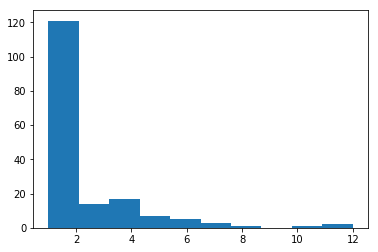

In [64]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

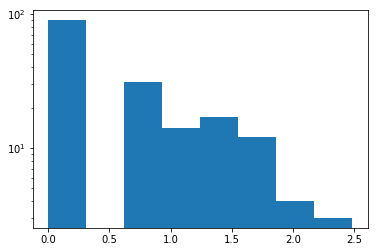

In [65]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(np.log(degrees), bins = int(len(G.nodes())/20), log = True)
    plt.show()

plot_degree_dist(G_undir)

In [66]:
degrees = [G.degree(n) for n in G.nodes()]
log_degrees = np.log(degrees)
print(np.mean(log_degrees), np.std(log_degrees), skew(log_degrees))


0.5605238122359343 0.6764864741642834 0.8388522244343659


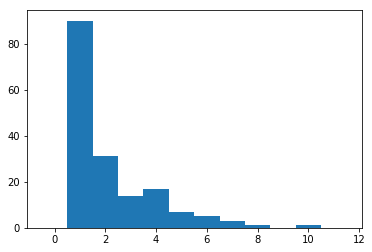

In [67]:
plt.hist(degrees, bins = np.arange(-0.5,max(degrees)+0.5,1))
plt.show()

In [68]:
degree_dist = np.zeros(max(degrees)+1)

In [69]:
for i in range(max(degrees)):
    degree_dist[i] = np.sum(np.array(degrees) == i)

In [70]:
degree_dist

array([ 0., 90., 31., 14., 17.,  7.,  5.,  3.,  1.,  0.,  1.,  0.,  0.])

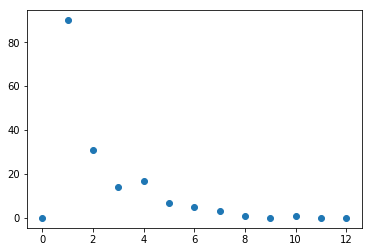

In [71]:
plt.scatter(np.arange(max(degrees)+1), degree_dist)
plt.show()

#### in-degree

0 48.0
1 81.0
2 21.0
3 10.0
4 8.0
5 1.0
6 2.0


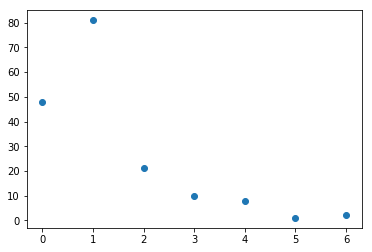

In [72]:
indegrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
indegree_dist = np.zeros(max(indegrees)+1)
for i in range(max(indegrees)+1):
    indegree_dist[i] = np.sum(np.array(indegrees) == i)
    print(i,indegree_dist[i])
plt.scatter(np.arange(max(indegrees)+1), indegree_dist)
plt.show()

In [73]:
# calculate for everything without 0 (artifact because of limited data)

In [74]:
indegree_dist

array([48., 81., 21., 10.,  8.,  1.,  2.])

In [75]:
x = np.arange(1,max(indegrees)+1)
y = indegree_dist[1:]

Logical = (y!= 0) # else the linear regression has to deal with - infinity
print(x[Logical])

regIN = LinearRegression().fit(np.log(x[Logical]).reshape(-1, 1),
                               np.log(y[Logical]).reshape(-1, 1))


[1 2 3 4 5 6]


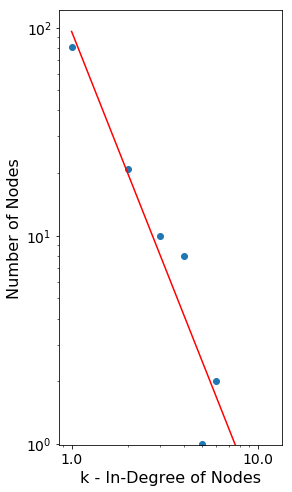

In [76]:
plt.figure(figsize=(4,8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
xrange = np.arange(1.0, 12,0.1)
plt.plot(xrange,np.exp(regIN.predict(np.log(xrange.reshape(-1, 1)))), "red" )
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - In-Degree of Nodes", fontsize = 16)
plt.ylabel("Number of Nodes", fontsize = 16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.savefig(year+"_InNodeDistrPlot",bbox_inches='tight')

plt.show()

In [77]:
regIN.coef_

array([[-2.25812047]])

In [78]:
print(np.log(y[Logical]), 
               np.log(x[Logical]))

[4.39444915 3.04452244 2.30258509 2.07944154 0.         0.69314718] [0.         0.69314718 1.09861229 1.38629436 1.60943791 1.79175947]


In [79]:

X = np.log(x[Logical]).reshape(-1,1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(y[Logical]), X)
resultIN = model.fit()
print(resultIN.bse[1])
print(resultIN.rsquared)



0.3979995349119091
0.8894740660525395


#### Out-Degree

In [80]:
outdegrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
outdegrees_dist = np.zeros(max(outdegrees)+1)
for i in range(max(outdegrees)+1):
    outdegrees_dist[i] = np.sum(np.array(outdegrees) == i)
    print(i,outdegrees_dist[i])


0 60.0
1 65.0
2 23.0
3 12.0
4 7.0
5 2.0
6 0.0
7 1.0
8 0.0
9 0.0
10 1.0


In [81]:
xout = np.arange(1,max(outdegrees)+1)
yout = outdegrees_dist[1:]


Logical = (yout!=0)*(xout>4) # else the linear regression has to deal with - infinity
                        # also x>4: Tail of distribution

regOUT = LinearRegression().fit(np.log(xout[Logical]).reshape(-1, 1),
                               np.log(yout[Logical]).reshape(-1, 1))


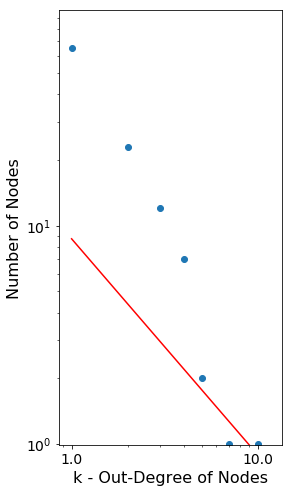

In [82]:
plt.figure(figsize=(4,8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(xout, yout)
plt.ylim(0.99, 1.5*max(yout))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")
plt.plot(xrange,np.exp(regOUT.predict(np.log(xrange.reshape(-1, 1)))), "red" )
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes", fontsize = 16)
plt.ylabel("Number of Nodes", fontsize = 16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.savefig(year+"_OutNodeDistrPlot",bbox_inches='tight')
plt.show()

In [83]:
regOUT.coef_[0][0]

-0.9900042121305287

In [84]:

X = np.log(xout[Logical]).reshape(-1,1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(yout[Logical]), X)
resultOUT= model.fit()
print(resultOUT.bse[1])
resultOUT.summary()

0.5940097140771771


/home/users/t_wand01/.local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     2.778
Date:                Tue, 25 Jan 2022   Prob (F-statistic):              0.344
Time:                        16:02:11   Log-Likelihood:                 1.0925
No. Observations:                   3   AIC:                             1.815
Df Residuals:                       1   BIC:                           0.01219
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1642      1.172      1.847      0.316     -12.728      17.056
x1            -0.9900      0.594     -1.667      0.344      -8.538       6.558
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.999
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.706   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OutSlopes=pd.DataFrame(data = {"Slope In-Degree": regIN.coef_[0],
                               "StandError Slope In": resultIN.bse[1],
                               "R^2 In-Degree":resultIN.rsquared,
                    "Slope Out-Degree": regOUT.coef_[0],
                              "StandError Slope Out": resultOUT.bse[1],
                              "R^2 Out-Degree":resultOUT.rsquared})
OutSlopes
#OutSlopes.to_csv(year+"_slopes.csv",index=False)


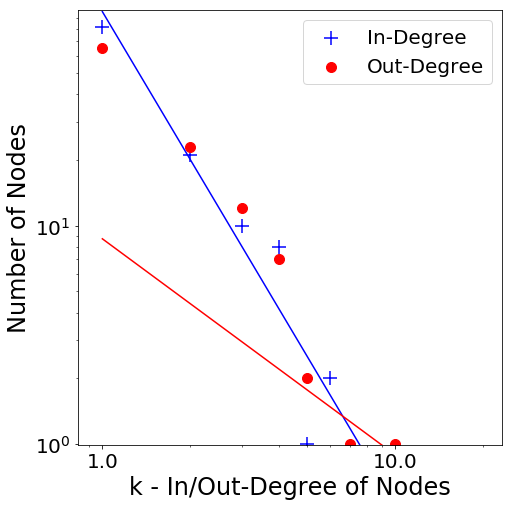

In [85]:
#plt.figure(figsize=(6.6,6))
plt.figure(figsize=(7.6,8))

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.99, 1.5*max(yout))
xrange = np.arange(1.0, 20,0.1)

# in
plt.scatter(x, y,s = 200, marker="+", color = "blue", label="In-Degree")
plt.plot(xrange,np.exp(regIN.predict(np.log(xrange.reshape(-1, 1)))), "blue" )

#out
plt.scatter(xout, yout,s = 100, color = "red", label="Out-Degree")
plt.plot(xrange,np.exp(regOUT.predict(np.log(xrange.reshape(-1, 1)))), "red" )


ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())


plt.xlabel("k - In/Out-Degree of Nodes", fontsize = 24)
plt.ylabel("Number of Nodes", fontsize = 24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.legend(fontsize = 20)
plt.savefig(year+"_DistributionsDegrees", dpi=1200,bbox_inches='tight')
plt.show()

### Clustering

In [86]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.DiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [87]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

0.7920792079207921

In [88]:
# Regular Clustering

Clust = networkx.algorithms.cluster.clustering(G_dir)
BDN_C = np.mean(list(Clust.values()))
print(BDN_C)

0.005404528231257977


In [89]:
WeightClust = networkx.algorithms.cluster.clustering(G_dir, weight = "fee_cleaned")

In [90]:
# Weighted Clustering
# https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107

WDN_C = np.mean(list(WeightClust.values()))  ## ?
print(WDN_C)

0.0005641221941457668


In [91]:
NumberNodes = len(list(G_dir.nodes))
NumberEdges = len(list(G_dir.edges))

p = 2*NumberEdges / (NumberNodes*(NumberNodes-1)) # p. 19 in Large Scale Structures....
print(p)

0.013897488820089439


Kind of like Eq. (11) in https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107
it holds that Clustering_WDN < Clustering_BDN ~ p_random

### Calculate Node Strength Distribution

In [92]:
l=0
for n in G.nodes():
    l = l+1
print(l)
print(len(G.nodes()))
print(int(len(G.nodes())/20))

171
171
8


0.005 47.035000000000004


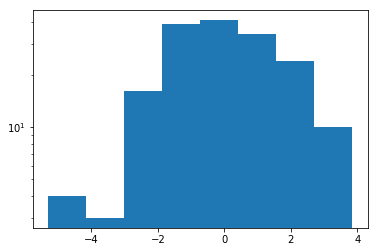

In [93]:
# Roughly symmetrical around 1.5?
def plot_strength_dist(G):
    strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
    plt.hist(np.log(strengths), bins = int(len(G.nodes())/20), log = True)
    print(min(strengths), max(strengths))
    #plt.savefig(year+"_LogStrengthDistrib")
    plt.show()
plot_strength_dist(G_dir)



In [94]:
strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
log_strengths = np.log(strengths)
print(np.mean(log_strengths), np.std(log_strengths), skew(log_strengths))

-0.03945399437544985 1.7145591235616526 -0.28881707688126934


### Disparity for undirected Network

In [95]:
A = networkx.linalg.graphmatrix.adjacency_matrix(G_undir, weight = "fee_cleaned")

In [96]:
print(A.shape)

(171, 171)


In [97]:
## Sanity check: should be 0
print(np.sum(A[i,i] for i in range(A.shape[0])))

0.0


/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [98]:
print(DF)

                   club_name club_involved_name  fee_cleaned
0                 1. FC Köln          Siarka T.        0.270
1                 1. FC Köln       A. Aachen II        0.014
2                 1. FC Köln         Bröndby IF        0.122
3        1.FC Kaiserslautern     1.FC Nuremberg        0.450
4        1.FC Kaiserslautern    Stuttg. Kickers        0.648
..                       ...                ...          ...
197             Wimbledon FC       Brentford FC        0.900
198             Wimbledon FC            Chelsea        0.747
199  Wolverhampton Wanderers            Norwich        0.340
200  Wolverhampton Wanderers           Coventry        0.101
201                York City         Stoke City        0.051

[202 rows x 3 columns]


In [99]:
print(A)

  (0, 1)	0.27
  (0, 2)	0.014
  (0, 3)	0.122
  (1, 0)	0.27
  (2, 0)	0.014
  (3, 0)	0.122
  (3, 25)	1.44
  (4, 5)	0.45
  (4, 6)	0.648
  (5, 4)	0.45
  (5, 7)	0.675
  (5, 8)	0.54
  (5, 23)	0.315
  (5, 24)	0.315
  (5, 112)	0.115
  (5, 120)	1.13
  (5, 165)	0.158
  (6, 4)	0.648
  (7, 5)	0.675
  (8, 5)	0.54
  (9, 10)	0.135
  (10, 9)	0.135
  (10, 119)	0.585
  (10, 153)	0.9
  (10, 154)	0.135
  :	:
  (155, 137)	1.35
  (156, 54)	0.008
  (157, 93)	0.15
  (158, 22)	0.405
  (158, 159)	0.005
  (159, 158)	0.005
  (160, 144)	0.131
  (160, 161)	0.029
  (161, 49)	0.113
  (161, 51)	0.081
  (161, 67)	0.078
  (161, 160)	0.029
  (162, 103)	0.405
  (163, 22)	0.491
  (164, 14)	0.135
  (165, 5)	0.158
  (165, 153)	1.13
  (166, 153)	1.35
  (167, 153)	0.158
  (168, 50)	0.282
  (168, 55)	0.747
  (168, 63)	0.9
  (169, 56)	0.34
  (169, 91)	0.101
  (170, 32)	0.051


In [100]:
strengths_undir = [G_undir.degree(n, weight="fee_cleaned") for n in G_undir.nodes()]

In [101]:
strengths_undir

[0.406,
 0.27,
 0.014,
 1.5619999999999998,
 1.098,
 3.698,
 0.648,
 0.675,
 0.54,
 0.135,
 1.755,
 0.277,
 0.034,
 6.3,
 47.03499999999999,
 4.05,
 18.990000000000002,
 1.35,
 22.074,
 4.109999999999999,
 0.817,
 0.013,
 3.6040000000000005,
 0.315,
 0.315,
 9.225000000000001,
 2.7,
 4.343999999999999,
 7.545,
 0.108,
 3.338,
 0.7070000000000001,
 0.5960000000000001,
 3.65,
 1.13,
 0.6080000000000001,
 0.338,
 0.27,
 18.46,
 2.88,
 10.0,
 2.25,
 2.25,
 0.328,
 1.0090000000000001,
 0.36,
 0.156,
 0.113,
 2.483,
 2.6649999999999996,
 0.45399999999999996,
 0.535,
 9.339999999999998,
 0.99,
 12.283000000000001,
 8.165999999999999,
 2.919,
 0.9,
 3.174,
 0.445,
 1.0670000000000002,
 26.509999999999998,
 0.104,
 1.305,
 0.09,
 2.371,
 5.258,
 0.411,
 0.905,
 1.0350000000000001,
 0.802,
 1.028,
 0.327,
 0.613,
 0.252,
 6.0120000000000005,
 2.7,
 2.7,
 2.044,
 2.3529999999999998,
 0.122,
 0.122,
 0.085,
 6.004000000000001,
 0.016,
 0.308,
 1.01,
 0.36,
 0.405,
 5.14,
 1.418,
 2.285,
 0.27,
 5.

In [102]:
j = 0
Y = np.zeros(A.shape[0])
for i in G_undir.nodes:
    row = (A[j,:]/np.sum(A[j,:]))
    row = row.toarray()
    Y[j] = np.sum(row**2)
    j = j+1
    
    
print(j)

171


In [103]:
degrees_undir = [G_undir.degree(n) for n in G_undir.nodes()]

In [104]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.log(degrees_undir).reshape(-1, 1), np.log(Y).reshape(-1, 1))

In [105]:
print(reg.coef_[0]) # reasonably close to -1?


[-0.7328621]


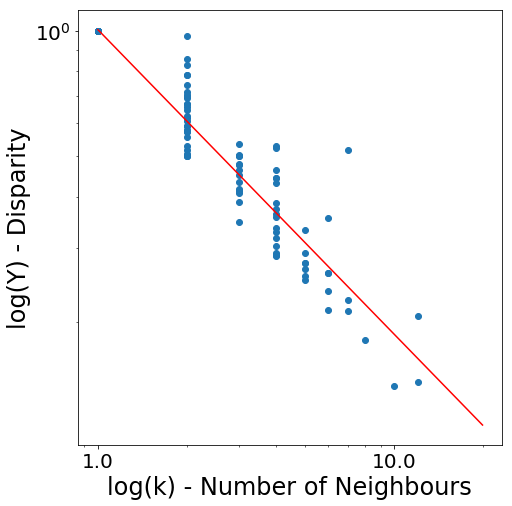

In [106]:


x = degrees_undir
y = Y
plt.figure(figsize=(7.6,8))
plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')

plt.plot(np.exp(np.arange(0,3,0.01)), 
        np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("log(k) - Number of Neighbours",fontsize=24)
plt.ylabel("log(Y) - Disparity",fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.savefig(year+"_DisparityPlot_new",dpi = 1200,bbox_inches='tight')

plt.show()


In [107]:

X = np.log(degrees_undir).reshape(-1, 1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(Y), X)
resultDisp= model.fit()
print(resultDisp.bse[1])
print(resultDisp.rsquared)
resultDisp.summary()

0.014800631869855781
0.9355157297771574


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2452.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          1.59e-102
Time:                        16:02:21   Log-Likelihood:                 106.03
No. Observations:                 171   AIC:                            -208.1
Df Residuals:                     169   BIC:                            -201.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.013      0.638      0.525      -0.017       0.034
x1            -0.7329      0.015    -49.516      0.000      -0.762      -0.704
==============================================================================
Omnibus:                       83.631   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.144
Skew:                           1.741   Prob(JB):                    1.34e-102
Kurtosis:                      10.329   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
OutSlopes=pd.DataFrame(data = {"Slope In-Degree": regIN.coef_[0],
                               "StandError Slope In": resultIN.bse[1],
                               "R^2 In-Degree":resultIN.rsquared,
                    "Slope Out-Degree": regOUT.coef_[0],
                              "StandError Slope Out": resultOUT.bse[1],
                              "R^2 Out-Degree":resultOUT.rsquared,
                              "Slope Disparity": reg.coef_[0],
                              "StandError Disparity":resultDisp.bse[1] ,
                              "R^2 Disparity":resultDisp.rsquared})
print(OutSlopes)
OutSlopes.to_csv(year+"_slopes.csv",index=False)

   Slope In-Degree  StandError Slope In  R^2 In-Degree  Slope Out-Degree  \
0         -2.25812                0.398       0.889474         -0.990004   

   StandError Slope Out  R^2 Out-Degree  Slope Disparity  \
0               0.59401        0.735289        -0.732862   

   StandError Disparity  R^2 Disparity  
0              0.014801       0.935516  


## Conclusion
Save some important results as an exported txt

In [109]:
Out = pd.DataFrame(data={"Year":year,
                         "NumberClubs": NumberNodes,
                         "NumberTransfers": DF_clean.shape[0],
                         "SmallWorldOmega": SW,
                        "DisparityExponent": reg.coef_[0],
                         "BDN_RandomClusteringExpecation": p,
                        "BDN_Clustering": BDN_C,
                        "WDN_Clustering":WDN_C,
                        "MeanLogStrength":np.mean(log_strengths), 
                         "StdLogStrength":np.std(log_strengths), 
                         "SkewnessLogStrength":skew(log_strengths)})

In [110]:
Out.to_csv(year+"_omega_results.csv",index=False)

In [111]:
Out

,Year,NumberClubs,NumberTransfers,SmallWorldOmega,DisparityExponent,BDN_RandomClusteringExpecation,BDN_Clustering,WDN_Clustering,MeanLogStrength,StdLogStrength,SkewnessLogStrength
0,1992,171,237,0.58149,-0.732862,0.013897,0.005405,0.000564,-0.039454,1.714559,-0.288817


In [112]:
year

'1992'